In [140]:
words = open('/content/drive/MyDrive/makemore/names.txt', 'r').read().splitlines()

**Bigram Model**

Predicts next character based on pairs of consecutive characters.


In [142]:
# its more convenient to store bigrams in a 2D array than a dict
import torch

In [143]:
N = torch.zeros((27, 27), dtype = torch.int32) # 26 chars in alphabet + 2 special chars (<S>, <E>)

In [144]:
chars = sorted(list(set(''.join(words)))) # sorted list of unique characters in words
stoi = {s:i+1 for i,s in enumerate(chars)} # mapping : char -> integer [1-26]
stoi['.']=0 # mapping : char -> integer [0-26]
itos = {i:s for s,i in stoi.items()} # reverse mapping : integer -> char [.-z]

In [173]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]): # store each char as its integer equivalent (mapped in stoi)
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] = N[ix1, ix2] + 1


In [146]:
# code by Andrej to visualize consecutive character frequencies
import matplotlib.pyplot as plt
%matplotlib inline

def plot_tensor(s, N):
  plt.figure(figsize=(s,s))
  plt.imshow(N, cmap='Blues')
  for i in range(27):
      for j in range(27):
          chstr = itos[i] + itos[j]
          plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
          plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray') # tensor.item() to extract the item from tensor
  plt.axis('off');

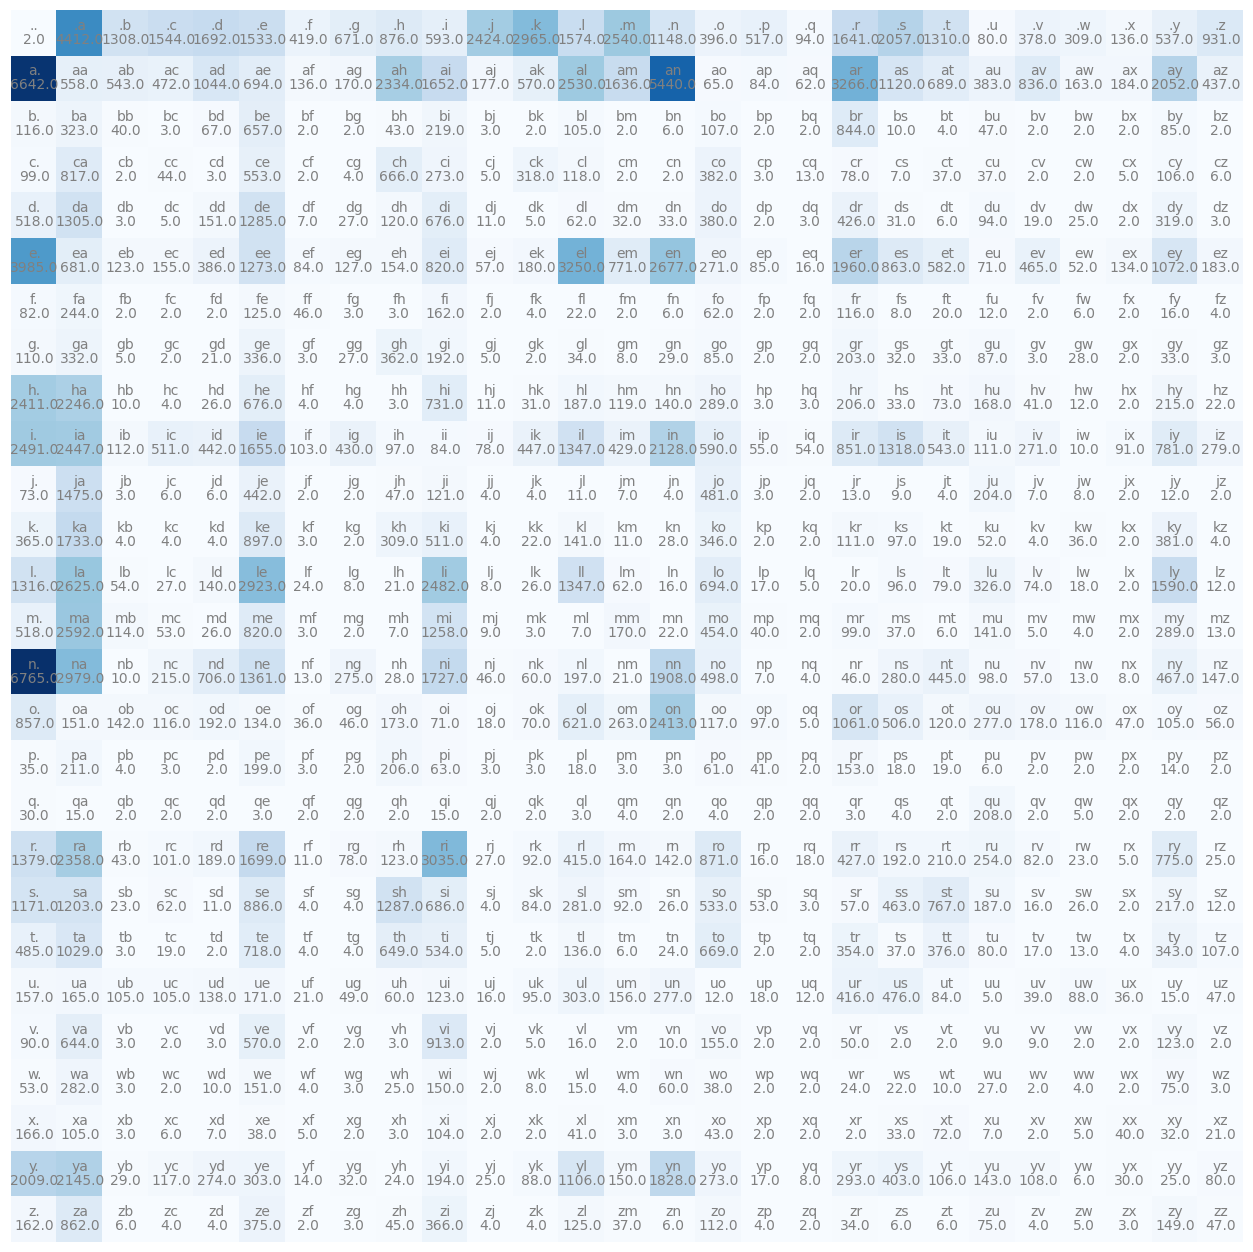

In [165]:
P = (N+2).float() # convert all char count values to floating points
plot_tensor(16, P)

In [166]:
# we want to divide all rows by their respective sums:
p=P.sum(1, keepdim=True) # sums every row and stores results in a [27, 1] tensor (column vector)
P=P/p # produces a probability distribution and stores in P (instead of instance count)
# i.e.
P[0] # probability of each character appearing first


tensor([6.2331e-05, 1.3750e-01, 4.0764e-02, 4.8119e-02, 5.2732e-02, 4.7776e-02,
        1.3058e-02, 2.0912e-02, 2.7301e-02, 1.8481e-02, 7.5545e-02, 9.2405e-02,
        4.9054e-02, 7.9160e-02, 3.5778e-02, 1.2341e-02, 1.6112e-02, 2.9295e-03,
        5.1142e-02, 6.4107e-02, 4.0827e-02, 2.4932e-03, 1.1780e-02, 9.6301e-03,
        4.2385e-03, 1.6736e-02, 2.9015e-02])

In [167]:
g = torch.Generator().manual_seed(2147483647) # deterministic seed / generator

for i in range(5):

  out = []

  ix = 0
  while True:
    pr = P[ix] # probabilities for next character
    ix = torch.multinomial(pr, num_samples=1, replacement=True, generator=g).item() # returns high likelihood next character index from the probability distribution (pr) for the previous character
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out).strip('.'))

cexze
momasurailezitynn
konimittain
llayn
ka


In [170]:
# a good model should produce probabilities close to 1 for bigrams in the training set.
# i.e. for the name "emma" -> given ".e", the probability of "em" should be ≈ 1.000
#                          -> given "em", the probability of "mm" should be ≈ 1.000, etc

avg_log_likelihood = 0.0
n = 3
i = 0

for w in words[:n]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]): # store each char as its integer equivalent (mapped in stoi)
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix]
    # log 0 = -inf and log 1 = 0
    # the goal is to minimize the negative log loss (bring -> 0)
    logprob = torch.log(P[ix1, ix2])
    avg_log_likelihood += logprob
    i += 1
    print(f'{ch1}{ch2}: {prob[ix2]:.4f}, negative_log_prob: {-logprob: .4f}')

print(f'average log likelihood: {avg_log_likelihood/i}') # we want to maximize this (-> 0)

.e: 0.0478, negative_log_prob:  3.0412
em: 0.0792, negative_log_prob:  3.2794
mm: 0.0792, negative_log_prob:  3.6735
ma: 0.1375, negative_log_prob:  0.9491
a.: 0.0001, negative_log_prob:  1.6312
.o: 0.0123, negative_log_prob:  4.3948
ol: 0.0491, negative_log_prob:  2.5544
li: 0.0185, negative_log_prob:  1.7308
iv: 0.0118, negative_log_prob:  4.1823
vi: 0.0185, negative_log_prob:  1.0569
ia: 0.1375, negative_log_prob:  1.9818
a.: 0.0001, negative_log_prob:  1.6312
.a: 0.1375, negative_log_prob:  1.9841
av: 0.0118, negative_log_prob:  3.7037
va: 0.1375, negative_log_prob:  1.4059
a.: 0.0001, negative_log_prob:  1.6312
average log likelihood: -2.426955461502075


Since we have the loss function, we can use gradient based optimization (backprop) to tune the model parameters

In [269]:
# creating training set of all bigrams
xs = [] # first character of bigram
ys = [] # second character of bigram

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]): # store each char as its integer equivalent (mapped in stoi)
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs.size())

torch.Size([228146])


In [270]:
import torch.nn.functional as F

In [271]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator = g, requires_grad=True) # initial weights for 27 neurons (input len = 27, num neurons = 27)


In [295]:
# forward pass
x_enc = F.one_hot(xs, num_classes=27).float() # one hot encode each x value (i.e. 2 -> [0.0 0.0 1.0 0.0...0.0])
logits = x_enc @ W # matrix multiplication - Σw.x = outputs of neurons
counts = logits.exp() # ensures all counts are positive (equiv. to N) : any log-count < 0 -> 0 < count < 1
probs = counts/counts.sum(1, keepdim=True)
probs # obtains probability distribution based on initial weights
loss = -probs[torch.arange(probs.size()[0]), ys].log().mean() # mean is important because backward can only be run on a scalar
print(loss.size())

torch.Size([])


In [296]:
print(itos[xs[1].item()], itos[ys[1].item()], probs[xs[1].item()][ys[1]].item())
print(itos[xs[2].item()], itos[ys[2].item()], probs[xs[2].item()][ys[2]].item())

e m 0.03390095755457878
m m 0.019329633563756943


In [297]:
loss

tensor(3.1531, grad_fn=<NegBackward0>)

clearly the weights are not it, but luckily (by design actually) all the elements are differentiable so we can back propogate

In [315]:

for i in range(100):

  # forward pass
  x_enc = F.one_hot(xs, num_classes=27).float() # one hot encode each x value (i.e. 2 -> [0.0 0.0 1.0 0.0...0.0])
  logits = x_enc @ W # matrix multiplication - Σw.x = outputs of neurons
  counts = logits.exp() # ensures all counts are positive (equiv. to N) : any log-count < 0 -> 0 < count < 1
  probs = counts/counts.sum(1, keepdim=True)
  probs # obtains probability distribution based on initial weights
  loss = -probs[torch.arange(probs.size()[0]), ys].log().mean() # mean is important because backward can only be run on a scalar

  # backward pass
  W.grad = None
  loss.backward(retain_graph=True) # sets gradient by backpropogating all the way to initial weights. theres just one layer anyway.

  # update
  W.data += -50 * W.grad

print(loss)


tensor(2.4577, grad_fn=<NegBackward0>)


In [316]:
print(itos[xs[1].item()], itos[ys[1].item()], probs[xs[1].item()][ys[1]].item())
print(itos[xs[2].item()], itos[ys[2].item()], probs[xs[2].item()][ys[2]].item())

e m 0.07921843230724335
m m 0.04822169989347458


In [317]:
# we can perform name generation using the probabilities generated by the neural network as well
for i in range(5):

  out = []

  ix = 0
  while True:
    pr = probs[ix] # probabilities for next character
    ix = torch.multinomial(pr, num_samples=1, replacement=True, generator=g).item() # returns high likelihood next character index from the probability distribution (pr) for the previous character
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out).strip('.'))

jrola
sravyrhlkhniydhknemlg
rash
ba
kd


P.S. i ran the backprop about 100 times so the loss is much much better than that of the static probability distribution. therefore we produce better names